In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

%matplotlib inline
plt.style.use('ggplot')
#plt.style.available

In [2]:
import string
import datetime as dt

from collections import OrderedDict

In [3]:
FMNIST_train = torchvision.datasets.FashionMNIST(root='.', train=True,download=True,transform=torchvision.transforms.ToTensor())


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
FMNIST_train.data

In [5]:
FMNIST_test = torchvision.datasets.FashionMNIST(root='.', train=False, download=True,transform=torchvision.transforms.ToTensor())

In [6]:
set(FMNIST_test.targets.numpy())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [171]:
class CNN(torch.nn.Module):

  def __init__(self,K):
    super(CNN,self).__init__()

    self.conv_layers = torch.nn.Sequential(
        OrderedDict([
        ('conv1',torch.nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2)),
        ('relu1',torch.nn.ReLU()),
        ('conv2',torch.nn.Conv2d(32,64,3,2)),
        ('relu2',torch.nn.ReLU()),
        ('conv3',torch.nn.Conv2d(64,128,3,2)),
        ('relu3',torch.nn.ReLU()),
        ('conv4',torch.nn.Conv2d(128,256,2,1)),
        ('relu4',torch.nn.ReLU())
        ])
    )

    self.dense_layers = torch.nn.Sequential(
        OrderedDict([
        ('drop1',torch.nn.Dropout(.2)),
        ('dense1',torch.nn.Linear(256,1024)),
        ('relu5', torch.nn.ReLU()),
        ('dense2',torch.nn.Linear(1024,512)),
        ('relu6', torch.nn.ReLU()),
        ('dense3',torch.nn.Linear(512,K))
        ])
    )

  def forward(self,x):
    x = self.conv_layers(x)
    # print(x.size())
    x=  x.view(x.size(0),-1) #torch.nn.Flatten()
    x = self.dense_layers(x)
    return x

In [172]:
K= len(set(FMNIST_test.targets.numpy()))

model = CNN(K)

In [173]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print("H/W:",device)

model.to(device)

H/W: cuda:0


CNN(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (relu1): ReLU()
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (relu2): ReLU()
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (relu3): ReLU()
    (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
    (relu4): ReLU()
  )
  (dense_layers): Sequential(
    (drop1): Dropout(p=0.2, inplace=False)
    (dense1): Linear(in_features=256, out_features=1024, bias=True)
    (relu5): ReLU()
    (dense2): Linear(in_features=1024, out_features=512, bias=True)
    (relu6): ReLU()
    (dense3): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [174]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr= .01)

In [175]:
batch_size = 256

train_loader  = torch.utils.data.DataLoader(dataset = FMNIST_train ,batch_size = batch_size,shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset = FMNIST_test ,batch_size = batch_size,shuffle=True)

In [180]:
class BatchGD():

  def __init__(self, model, loss, optim):
    self.model = model
    self.train_loss = []
    self.test_loss = []
    self.loss= loss
    self.optimizer = optim

  def train(self,n_iter, train_loader,test_loader, device):

    for _ in range(n_iter):
      _test_loss=[]
      _train_loss=[]
      for input,target in train_loader:

        inputs,target = input.to(device), target.to(device)

        self.optimizer.zero_grad()

        output = self.model(inputs)
        _loss = self.loss(output,target)

        _train_loss.append(_loss.item())

        _loss.backward()
        self.optimizer.step()

        
      # to plot test-error as well
      for input,target in test_loader:

        inputs,target = input.to(device), target.to(device)

        self.optimizer.zero_grad()

        output = self.model(inputs)
        _loss = self.loss(output,target)

        _test_loss.append(_loss.item())

      self.train_loss.append(torch.mean(torch.tensor(_train_loss)).item())
      self.test_loss.append(torch.mean(torch.tensor(_test_loss)).item())

      print("Iteration:",_,"Train Loss:",self.train_loss[-1],"Test Loss:", self.test_loss[-1])

  def getloss(self):
    return self.train_loss, self.test_loss

  def plot_loss(self):
    plt.close()
    plt.plot(self.train_loss, label="train-loss")
    plt.plot(self.test_loss, label ="test-loss")
    plt.legend()
    plt.show()



In [181]:
batchGD = BatchGD(model, loss, optimizer)

In [182]:
batchGD.train(10,train_loader,test_loader,device)

Iteration: 0 Train Loss: 0.3970552682876587 Test Loss: 0.43429675698280334
Iteration: 1 Train Loss: 0.3913622796535492 Test Loss: 0.4496951103210449
Iteration: 2 Train Loss: 0.3920009136199951 Test Loss: 0.43301376700401306
Iteration: 3 Train Loss: 0.38340747356414795 Test Loss: 0.4312871992588043
Iteration: 4 Train Loss: 0.38667812943458557 Test Loss: 0.44450458884239197
Iteration: 5 Train Loss: 0.38012412190437317 Test Loss: 0.4347914755344391
Iteration: 6 Train Loss: 0.39170247316360474 Test Loss: 0.44247540831565857
Iteration: 7 Train Loss: 0.3851177394390106 Test Loss: 0.4280429780483246
Iteration: 8 Train Loss: 0.38493120670318604 Test Loss: 0.4484136700630188
Iteration: 9 Train Loss: 0.3790391981601715 Test Loss: 0.42758068442344666


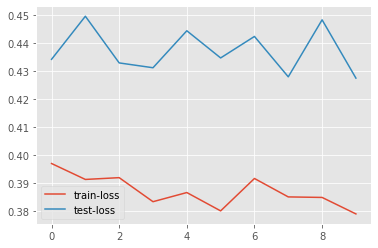

In [183]:
batchGD.plot_loss()

In [206]:
''' 
query_data = test_loader.dataset.data[query]
query_data = torch.unsqueeze(query_data,0) '''

inputs,labels=next(iter(test_loader))


Text(0.5, 1.0, 'True label:2')

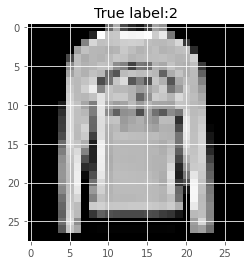

In [241]:
query = np.random.choice(range(255))
plt.imshow(inputs[query].reshape(28,28),cmap='gray')
plt.title("True label:{}".format(labels[query].item()) )

In [242]:
torch.unsqueeze(inputs[query],0).shape
query_data = torch.unsqueeze(inputs[query],0)
out = model.forward(query_data.to(device))
cls = torch.argmax(out)
cls.item()

2